In [1]:
import pandas as pd
import numpy as np
import datetime
from dateutil import relativedelta
import matplotlib.pyplot as plt
from scipy.stats import genpareto, norm
import math

In [2]:
np.warnings.filterwarnings('ignore')

# Objective

The aim of this notebook is to take an insight on the VaR (Value at Risk) mechanic using the EVT (Extreme Value Theory). This approach takes into account a very common feature in capital markets which other methodologies don't consider, and it is the fat tails.

Fat tails do contain valuable information, specially in asset's returns, where might be hidden some extreme values not incorporated in market risk figures when the approach makes assumptions such as normality. The assumption may hurts your portfolio if it is not well assessed in your asset's return.

Some basic VaR forms such as parametrical VaR takes a view of asset's returns as a random variable wich is described by a normal distribution, thus omiting the fat tails.

# Data Reading

To complete this goal, we get data of American Express (AXP) close prices from 3-Jan-2019 to 3-Jan-2020 (filtered). The selection of this stock was random, and no was an output of rigurous study of stocks behaviour. The data was retrieved of <a href='https://www.investing.com/equities/american-express'>Investing.com</a> webpage.

In [3]:
prices = pd.read_csv('datasource/AXP Historical Data.csv')

In [4]:
prices['Date'] = prices['Date'].apply(lambda x: datetime.datetime.strptime(x,'%b %d, %Y'))
prices.sort_values(['Date'], inplace=True)
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

In [5]:
prices['return'] = prices['Price'].pct_change() * 100

## Filtering to get only the last year of historical prices

In [6]:
prices = prices[prices.index >= prices.index.max() + relativedelta.relativedelta(years=-1)]

# American Express returns histogram

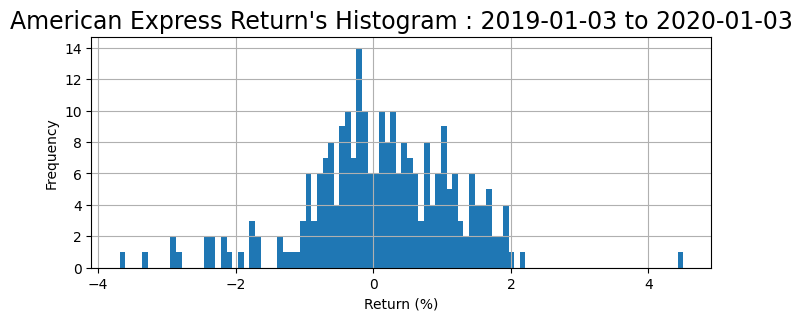

In [7]:
plt.figure(figsize=(8,3))
plt.hist(prices['return'], bins=100)
plt.title(
    'American Express Return\'s Histogram : '+
    min(prices.index).strftime('%Y-%m-%d')+
    ' to '+
    max(prices.index).strftime('%Y-%m-%d'),
    fontsize=17
)
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [8]:
print('Mean\t\t : ',prices['return'].mean())
print('Variance\t : ',prices['return'].var())
print('Skewness\t : ',prices['return'].skew())
print('Kurtosis\t : ',prices['return'].kurtosis())

Mean		 :  0.11026339006964607
Variance	 :  1.1670969421249096
Skewness	 :  -0.34864704438785554
Kurtosis	 :  1.5194279933506945


Is clear with histogram above, the American Express returns don't be described by normal distribution, because it has excess of kurtosis greater than zero (normal distribution has kurtosis = 3), although it has lowest negative skewness of -0.34. In many textbooks point out if distribution has kurtosis greatest than 3, is leptokurtic and then it could has fat-tails. This approach has a broad discution, because it is not necessarilly true <a href='http://www.columbia.edu/~ld208/psymeth97.pdf'>(see DeCarlo, 1997)</a>.

# EVT (Extreme Value Theory)

This is a field into statistics, where the main object of study are events in more unusually large or small levels of a random variable <a href='http://www.dii.uchile.cl/~ceges/publicaciones/ceges51.pdf'>(Fernandez, 2003)</a>. This techniques were developed initially in hydrology and engineering, and after was extended to financial field.

This field is a broad topic in statistics where we can find some distributions with fat-tails, nevertheles, in this case to financial risk management, we point out one of the most representative fat-tailed distributions. This is the Pareto distribution. This was a distribution developed by Vilfrido Pareto, and is used to describe the distribution of incomes (this could be related to Pareto Law).

After Pareto distribution, a generalized distribution was developed and it very useful, named Generalized Pareto Distribution (GPD). It is an important distribution in EVT, because using this we could complete the Balkema and de Haan theorem, and using a threshold analyze the tails distribution, <a href='http://www.iam.fmph.uniba.sk/institute/jurca/qrm/Chapter4.pdf'>(see Jurca, of Univerzita Komensheko, chapter 4)</a>. The aim of using a threshold is to separate only values considered as extrem values from the other values, in random variable distribution. This let to work with a model which describe them, and just them <a href='https://link.springer.com/book/10.1007/978-1-4471-3675-0'>(see Coles, 2001, pag. 78)</a>. A method which give to us the tools to do it, is named Peak Over Threshold Method (POT-method)  <a href='http://www.diva-portal.org/smash/get/diva2:1231783/FULLTEXT01.pdf'>(see Rydman, 2018)</a>.

The GPD function is defined by:<br><br>
$F(x) = 1 - \left( 1 - \frac{\xi x}{\sigma}\right)^\frac{1}{\xi}$<br><br>
As you can see above, it has two parameters, called <b>$\xi$</b> which gives the shape to distribution and <b>$\sigma$</b> which is defined as the scale parameter in the Pareto distribution.

## Threshold setting

As we said before, this approach is looking to describe the tails behaviour. To do this task, is useful POT-method, to determine data which are in tails to model them. This step is important because this involves to set a balance between bias and variance <a href='https://ine.pt/revstat/pdf/rs120102.pdf'>(see Scarrott & MacDonald, 2012)</a>. Quoting Scarrott, et al., <i>"The threshold must be sufficiently high to ensure that the asymptotics underlying the GPD approximation are reliable, thus reducing the bias. However, the reduced sample size for high thresholds increases the variance of the parameter estimates."</i>

Following Coles (2001), we need to calculate the threshold excess, wich is the distance between data points above threshold and the threshold, but this must be testing different thresholds. The goal with this is to identify what is the point <b>(threshold, mean excess)</b> which break an aproximatelly linear behaviour.

We did take negative returns in positive sign of the last nearest year.

In [9]:
number_steps = 40
negative_returns = prices[prices['return'] < 0][['return']] * -1
step_size = (negative_returns.max().values[0] - negative_returns.min().values[0]) / number_steps

In [10]:
print('Min\t\t:\t',negative_returns.min().values[0])
print('Max\t\t:\t',negative_returns.max().values[0])
print('Number Steps\t:\t',number_steps)
print('Step size\t:\t',step_size)

Min		:	 0.008271298593887089
Max		:	 3.688558109102802
Number Steps	:	 40
Step size	:	 0.09200717026272287


In [11]:
mean_residual_life = pd.DataFrame(columns=['threshold','threshold_excess', 'quantity'])

for i in range(number_steps):
    threshold_ = negative_returns.min().values[0] + (i*step_size)
    negative_returns_ = negative_returns[negative_returns['return'] > threshold_]
    negative_returns_['threshold_excess'] = negative_returns_['return'] - threshold_
    
    mean_residual_life.loc[len(mean_residual_life)] = [
                                                        threshold_,
                                                        negative_returns_['threshold_excess'].mean(),
                                                        negative_returns_.shape[0]
                                                        ]
    del negative_returns_, threshold_

In [12]:
mean_residual_life.head(10)

,threshold,threshold_excess,quantity
0,0.008271,0.778916,115.0
1,0.100278,0.720660,110.0
2,0.192286,0.742611,94.0
3,0.284293,0.762527,81.0
4,0.376300,0.717349,76.0
5,0.468307,0.752642,64.0
6,0.560314,0.749027,57.0
7,0.652321,0.788492,48.0
8,0.744329,0.825432,41.0
9,0.836336,0.893346,34.0


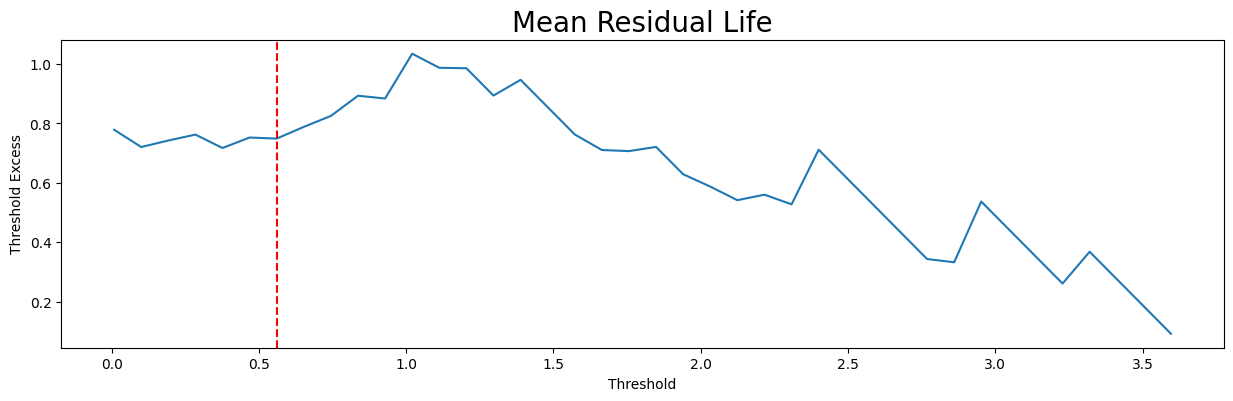

In [13]:
plt.figure(figsize=(15,4))

threshold_selected_ = 0.560314

plt.title('Mean Residual Life', fontsize=20)
plt.plot(mean_residual_life['threshold'], mean_residual_life['threshold_excess'])
plt.axvline(x=threshold_selected_, color='r', linestyle='--')
plt.ylabel('Threshold Excess')
plt.xlabel('Threshold')
plt.show()

The Mean Residual Life, designed by Coles (2001) did say us the threshold to capture the data which was used to determine the $\xi$ and $\sigma$ parameters in Generalized Pareto Distribution. <i>Initially, and for now, the selection was done graphically, saying with this which for future works of this subject, we will improve this aspect including some metric or matematical procedure to identify this threshold point</i>.

## Parameters Estimation

Having seen a very brief introduction of EVT before, we cuould say that is necessary to get two fundamental parameters to solve GPD, being $\sigma$ as scale parameter and $\xi$ as shape parameter in GPD distribution. This parameters could be resolved by maximum likelihood method, as was described by Grimshaw (Computing maximum likelihood estimates for the generalized pareto distribution, 1993). But this parameters don't have a closed-form solution <a href='https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2608&context=jmasm'>(see Pahm & Tsokos & Choi, 2019)</a>. Because it we did get the parameters of GPD using genpareto function in <b>scipy.stats</b> python package. This function returns shape $\xi$, location $\mu$, and scale $\sigma$

In [14]:
shape, location, scale = genpareto.fit(
                            negative_returns[
                                (~negative_returns['return'].isnull())
                                &
                                (negative_returns['return'] >= threshold_selected_)
                            ]['return'].values.tolist()
                            )

In [15]:
print('Shape\t\t:',shape)
print('Location\t:',location)
print('Scale\t\t:',scale)

Shape		: 0.08841097073305909
Location	: 0.5660822295123396
Scale		: 0.6722907865381664


# Value at Risk (VaR)

## EVT

As was pointed out by Fernandez (2003), an estimate VaR-EVT is defined as:

$\hat{VaR} = \mu + \frac{\hat{\beta}}{\hat{\xi}}\left( \left( \alpha\frac{N}{N_u} \right)^{-\xi}-1 \right)$

In this formula the parameters $N_u$ is the number of data points whose returns are above threshold, $N$ is the size of returns including negative and positive returns and $\alpha$ parameter is the significance level. The $\mu$ parameter is not the mean, so it should not be confused with $\mu_{parametricVaR}$

In [16]:
# nu_ is the size of negative returns which are bigger, than threshold
nu_ = negative_returns[
            (~negative_returns['return'].isnull())
            &
            (negative_returns['return'] >= threshold_selected_)
        ].shape[0]

# n_ is the size of returns
n_ = prices.shape[0]

In [17]:
def calculate_var_evt(location, scale, shape, n, nu, significance):
    var_evt = location + (scale / shape) * ( math.pow(significance * n  / nu,-shape) - 1)
    return var_evt

In [18]:
evt_test = pd.DataFrame(columns=['significance_level', 'var_evt'])
for significance_i in np.arange(0.005,0.07,0.005).tolist():
    var_evt = calculate_var_evt(location=location, scale=scale, shape=shape, n=n_, nu=nu_, significance=significance_i)
    evt_test.loc[len(evt_test)] = [significance_i, var_evt]
    del var_evt

In [19]:
evt_test

,significance_level,var_evt
0,0.005,3.609820
1,0.010,2.976889
2,0.015,2.624236
3,0.020,2.381581
4,0.025,2.197568
5,0.030,2.049890
6,0.035,1.926874
7,0.040,1.821659
8,0.045,1.729879
9,0.050,1.648584


## Parametric

The simple case of parametric VaR, consist in take the assumption, commonly taught in finance field, where asset returns have normal distribution. Before we said this assumption make difficult some analysis within fat-tails, and this is the reason to calculate this, to take a view of that. The calculous formula is:

$\hat{VaR} = \mu + \sigma Z_\alpha$

Where $\mu$ is the mean of returns, $\sigma$ is the standar deviation of returns and $Z_\alpha$ is the standarized value at a $\alpha$ significance level.

In [20]:
mean_ = prices['return'].mean()
std_ = prices['return'].std()

In [21]:
def calculate_var_parametric(mean, std, significance):
    var_par = mean + std * norm.ppf(significance, loc=0, scale=1)
    return var_par

In [22]:
parametric_test = pd.DataFrame(columns=['significance_level', 'var_parametric'])
for significance_i in np.arange(0.005,0.07,0.005).tolist():
    var_parametric = calculate_var_parametric(mean=mean_, std=std_, significance=significance_i)
    parametric_test.loc[len(parametric_test)] = [significance_i, -var_parametric]
    del var_parametric

In [23]:
parametric_test

,significance_level,var_parametric
0,0.005,2.672463
1,0.010,2.402943
2,0.015,2.234134
3,0.020,2.108448
4,0.025,2.007130
5,0.030,1.921600
6,0.035,1.847185
7,0.040,1.781042
8,0.045,1.721313
9,0.050,1.666709


## Comparison

In [24]:
df_test = pd.merge(
                evt_test,
                parametric_test,
                on=['significance_level'],
                how='outer'
            )

df_test['differences'] = df_test['var_evt'] - df_test['var_parametric']

In [25]:
df_test.to_csv('datasource/results/EVT/evt_results.csv', index=False)

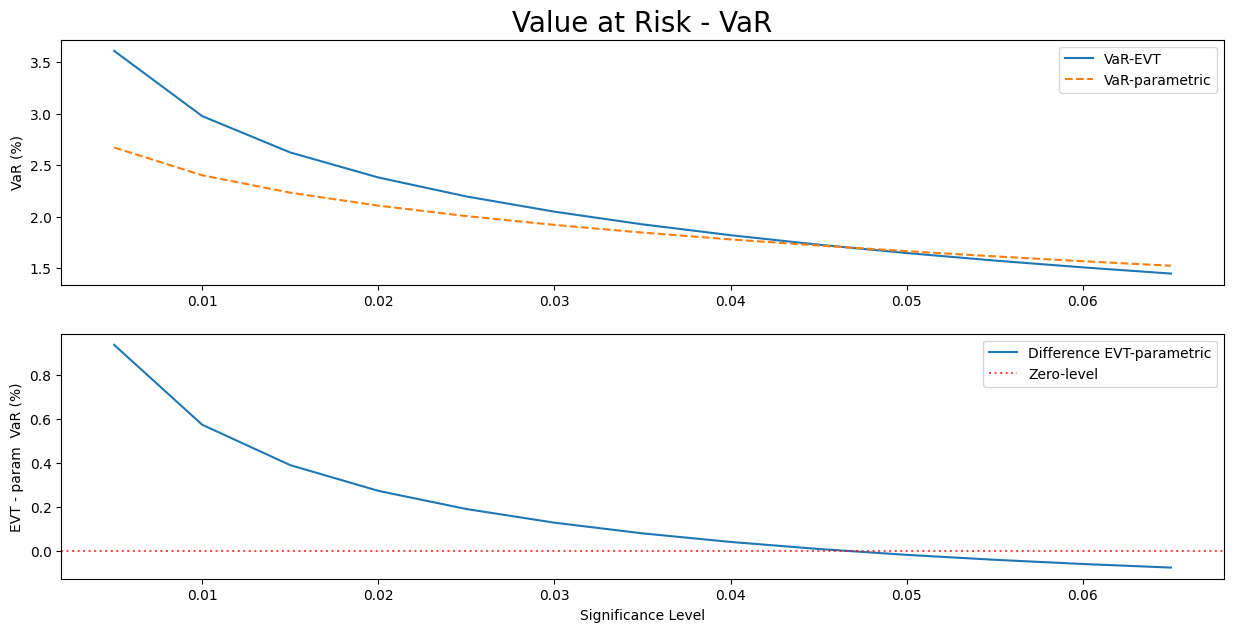

In [26]:
plt.figure(figsize=(15,7))

plt.subplot(2,1,1)
plt.plot(df_test['significance_level'], df_test['var_evt'], label='VaR-EVT')
plt.plot(df_test['significance_level'], df_test['var_parametric'], label='VaR-parametric', linestyle='--')
plt.title('Value at Risk - VaR', fontsize=20)
plt.ylabel('VaR (%)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_test['significance_level'], df_test['differences'], label='Difference EVT-parametric')
plt.axhline(y=0, color='r', linestyle='dotted', alpha=0.7, label='Zero-level')
plt.ylabel('EVT - param  VaR (%)')
plt.xlabel('Significance Level')
plt.legend()

plt.show()

# Conclusion

Comparing two methods to calculate VaR, we found the EVT method give us a biggest level of losses than parametric, but not in all significance levels. Was particularly interesting to see the difference between EVT output substracting parametric output at the same significance level, tend to be lower, passing throught zero nearest 5% significance level. Nevertheless, as was described by XXXX, "VaR calculated from EVT will be bigger than historical-simulation VaR and normal VaR, especially at high confidence levels.." <a href='https://www.amazon.com/Enterprise-Risk-Analytics-Capital-Markets/dp/1491744928'>(see Reddy, 2014, page 158)</a>

# Bibliography

* <b>Coles, S. (2001)</b>. An introduction to statistical modeling extreme values.
* <b>DeCarlo, L. (1997)</b>. On the meaning and use of kurtosis. American psycological association, Inc.
* <b>Fernandez, V. (2003)</b>. Extreme value theory: Value at risk and returns dependence around the world.
* <b>Jurca, P. (2019)</b>. Course cuantitative methods of risk management. Univerzita Komensheko.
* <b>Pham, M. & Tsokos, C. & Choi, B. (2019)</b>. Maximum likelihood estimation for the generalized pareto distribution and goodness of fit test with censored data. Vol, 17. Number 2.
* <b>Reddy, R. (2014)</b>. Enterprise risk analytics for capital markets: proactive and real-time risk management.
* <b>Rydman, M. (2018)</b>. Application of the Peak-Over-Threshold method on insurance data.
* <b>Scarrott, C. & MacDonald, A. (2012)</b>. A review of extreme value threshold estimation and uncertainty quantification. Vol, 10. Number 1.

<hr>

This could not to be the final version, so if you have some recommendation or comment about this, I will be grateful to hear it, using e-mail <b>craquinterogo@unal.edu.co</b> or <b>cristian.quintero@est.uexternado.edu.co</b>